<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/Assignment18/Assignment_18(Video_Stabilization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/roulupen/deeplib.git

Cloning into 'deeplib'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 165 (delta 0), reused 1 (delta 0), pack-reused 161
Receiving objects: 100% (165/165), 81.71 MiB | 32.25 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
!ls ./deeplib/my_data/video_stabilization/

shape_predictor_5_face_landmarks.dat   video.mp4
shape_predictor_68_face_landmarks.dat


In [0]:
# Delete directory if already present otherwise do nothing
!rm -rf ./result/final_frame
!rm -rf ./result/output_video

In [0]:
# Create required directories
!mkdir -p ./result/final_frame
!mkdir -p ./result/output_video

In [5]:
import cv2, dlib
import numpy as np
import math, sys
import os
import copy

import deeplib.util.faceBlendCommon as fbc
from deeplib.util.video_util import make_video_from_image_directory
from deeplib.util.video_util import make_video
from deeplib.util.video_util import concat_tile_resize

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [0]:
def align_image_using_5point_detection(face_detector, land_mark_detector, im, height_output, width_output):

    # Detect landmarks.
    points = fbc.getLandmarks(face_detector, land_mark_detector, im)

    points = np.array(points)

    # Convert image to floating point in the range 0 to 1
    im = np.float32(im)/255.0

    # Normalize image to output coordinates.
    imNorm, points = fbc.normalizeImagesAndLandmarks((im.shape[0], im.shape[1]), im, points)

    imNorm = np.uint8(imNorm*255)

    return imNorm

# Function to calculate the intereye distance.
def interEyeDistance(predict):
    leftEyeLeftCorner = (predict[36].x, predict[36].y)
    rightEyeRightCorner = (predict[45].x, predict[45].y)
    distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
    distance = int(distance)
    return distance

In [0]:
# GIT DATA PATH
GIT_DATA_PATH = './deeplib/my_data/video_stabilization/'

# Landmark model location
PREDICTOR_PATH = os.path.join(GIT_DATA_PATH, 'shape_predictor_68_face_landmarks.dat')

# Landmark model location
PREDICTOR_PATH_5POINT = os.path.join(GIT_DATA_PATH, 'shape_predictor_5_face_landmarks.dat')

# Input video file
videoFileName = os.path.join(GIT_DATA_PATH, "video.mp4")

# Final frames
FINAL_FRAMES_PATH = './result/final_frame'

# Output Video path
OUTPUT_VIDEO_PATH = './result/output_video'

In [0]:
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)
land_mark_detector_5point = dlib.shape_predictor(PREDICTOR_PATH_5POINT)

In [0]:
RESIZE_HEIGHT = 480

eyeDistanceNotCalculated = True
eyeDistance = 0
fps = 30
count = 0

winSize = 101
maxLevel = 5

# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

In [0]:
# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
    print("Unable to load video")

In [12]:
while(True):

    # Grab a frame
    ret, im = cap.read()

    # Bail out when the video file ends
    if not ret:
        break

    # Finding the size of the image.
    size = im.shape[0:1]

    # Keeeping Original frame
    im_original = copy.deepcopy(im)
    cv2.putText(im_original, "Original", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

    count += 1
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # COnverting to grayscale
    imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    height = im.shape[0]
    IMAGE_RESIZE = float(height)/RESIZE_HEIGHT

    # Resize image for faster face detection
    imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
    imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)

    img_aligned = align_image_using_5point_detection(detector, land_mark_detector_5point, im, None, None)
    cv2.putText(img_aligned, "Aligned".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

    faces = detector(imSmallDlib, 0)

    # If no face was detected
    if len(faces) == 0:
        print("No face detected")
    else:
        for i in range(0, len(faces)):

            # Face detector was found over a smaller image.
            # So, we scale face rectangle to correct size.
            newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
                int(faces[i].top() * IMAGE_RESIZE),
                int(faces[i].right() * IMAGE_RESIZE),
                int(faces[i].bottom() * IMAGE_RESIZE))

            # Detect landmarks in current frame
            landmarks = landmarkDetector(imDlib, newRect).parts()

            # Handling the first frame of video differently,for the first frame copy the current frame points
            if (count == 1):
                pointsPrev=[]
                pointsDetectedPrev = []
                [pointsPrev.append((p.x, p.y)) for p in landmarks]
                [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]
            # If not the first frame, copy points from previous frame.
            else:
                pointsPrev=[]
                pointsDetectedPrev = []
                pointsPrev = points
                pointsDetectedPrev = pointsDetectedCur

            # pointsDetectedCur stores results returned by the facial landmark detector
            # points stores the stabilized landmark points
            points = []
            pointsDetectedCur = []
            [points.append((p.x, p.y)) for p in landmarks]
            [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

            # Convert to numpy float array
            pointsArr = np.array(points, np.float32)
            pointsPrevArr = np.array(pointsPrev, np.float32)

        # If eye distance is not calculated before
        if eyeDistanceNotCalculated:
            eyeDistance = interEyeDistance(landmarks)
            eyeDistanceNotCalculated = False

        if eyeDistance > 100:
            dotRadius = 3
        else:
            dotRadius = 2

        sigma = eyeDistance * eyeDistance / 400
        s = 2 * int(eyeDistance/4)+1

        #  Set up optical flow params
        lk_params = dict(winSize  = (s, s), maxLevel = maxLevel, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
        pointsArr, status, err = cv2.calcOpticalFlowPyrLK(im, imDlib, pointsPrevArr, pointsArr, **lk_params) 

        # Converting to float
        pointsArrFloat = np.array(pointsArr,np.float32)

        # Converting back to list
        points = pointsArrFloat.tolist()

        # Final landmark points are a weighted average of
        # detected landmarks and tracked landmarks
        for k in range(0,len(landmarks)):
            d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
            alpha = math.exp(-d*d/sigma)
            points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

        # For capturing unstabilized frame points
        im_u = copy.deepcopy(im)

        # Stabilized points
        for p in pointsDetectedCur:
            cv2.circle(im, (int(p[0]),int(p[1])), dotRadius, (0, 0, 255), -1)

        # Display the landmarks points
        cv2.putText(im, "Stabilized", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

        # Unstabilized points
        for p in points:
            cv2.circle(im_u, (int(p[0]),int(p[1])), dotRadius, (255, 0, 0), -1)

        # Display the landmarks points
        cv2.putText(im_u, "Unstabilized", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

        im_final = concat_tile_resize([[im_original, img_aligned],[im_u, im]])
        name_final = '{0}_IMG.jpg'.format(count)
        name_final = os.path.join(FINAL_FRAMES_PATH, name_final)
        cv2.imwrite(name_final, im_final)
        print('writing to file: {0}'.format(name_final))
cap.release()

writing to file: ./result/final_frame/1_IMG.jpg
writing to file: ./result/final_frame/2_IMG.jpg
writing to file: ./result/final_frame/3_IMG.jpg
writing to file: ./result/final_frame/4_IMG.jpg
writing to file: ./result/final_frame/5_IMG.jpg
writing to file: ./result/final_frame/6_IMG.jpg
writing to file: ./result/final_frame/7_IMG.jpg
writing to file: ./result/final_frame/8_IMG.jpg
writing to file: ./result/final_frame/9_IMG.jpg
writing to file: ./result/final_frame/10_IMG.jpg
writing to file: ./result/final_frame/11_IMG.jpg
writing to file: ./result/final_frame/12_IMG.jpg
writing to file: ./result/final_frame/13_IMG.jpg
writing to file: ./result/final_frame/14_IMG.jpg
writing to file: ./result/final_frame/15_IMG.jpg
writing to file: ./result/final_frame/16_IMG.jpg
writing to file: ./result/final_frame/17_IMG.jpg
writing to file: ./result/final_frame/18_IMG.jpg
writing to file: ./result/final_frame/19_IMG.jpg
writing to file: ./result/final_frame/20_IMG.jpg
writing to file: ./result/fin

In [13]:
final_video_path = make_video_from_image_directory(FINAL_FRAMES_PATH, OUTPUT_VIDEO_PATH, "finall_video.mp4", 30)
print(final_video_path)

./result/output_video/finall_video.mp4


If below file download code fails to download then please navigate to the file browser from left panel and download "final_video.mp4"

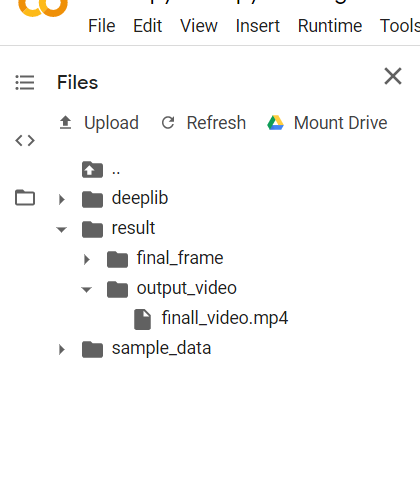

In [14]:
from google.colab import files
files.download(final_video_path)

MessageError: ignored